<a href="https://colab.research.google.com/github/jiahui989/Projects/blob/main/Car%20Insurance%20Approval%20Prediction/Development_of_Predictive_Model_on_Car_Insurance_Approval_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-model-analysis
!pip install tensorflow-addons

In [ ]:
import pandas as pd
df = pd.read_csv('/content/cleaned_car_insurance_dataset.csv', index_col='Unnamed: 0')
df.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,INCOME,VEHICLE_YEAR,POSTAL_CODE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,CREDIT_SCORE,ANNUAL_MILEAGE,PAST_ACCIDENTS,OUTCOME
0,0.953343,-0.622033,-0.354414,-0.898978,-0.384870,1.594129,0.184547,0.223370,0.500337,-0.701112,0.532798,0.078642,-0.136456,0.0
1,-2.537095,-0.802031,0.146777,-0.147050,0.303880,-0.340219,0.361956,-0.381019,0.240873,0.248644,0.022340,-0.273917,-0.108320,1.0
2,-1.385940,-0.290501,-1.482303,-1.232866,-0.422788,-0.479020,-0.578699,0.117883,-0.391011,-0.245258,0.527691,-0.291033,-0.089770,0.0
3,-2.382989,1.825815,-1.578011,0.208343,0.042549,-0.239941,0.408163,0.232866,-0.369905,-0.603366,-0.337437,0.258680,-0.116753,0.0
4,-0.886031,1.549266,-1.416426,0.222215,0.687438,-0.327309,0.337817,0.076373,-0.445377,-0.195532,0.264539,-0.558849,-0.091635,1.0


In [ ]:
df.shape

(10000, 14)

In [ ]:
import tensorflow as tf
import tensorflow_model_analysis as tfma
import tensorflow_addons as tfa
from tensorflow.keras import layers
from sklearn.metrics import classification_report

In [ ]:
X = df.iloc[:,:13]
Y = df.iloc[:,-1]

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=30, test_size=0.2, random_state=42)
sss.get_n_splits(X, Y)

for train_index, test_index in sss.split(X, Y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(8000, 13) (8000,)
(2000, 13) (2000,)


In [ ]:
predictive_model = tf.keras.Sequential(layers=[
                                               layers.Dense(13, input_shape=(13,), activation='relu'),
                                               layers.Dense(8),
                                               layers.Dense(4),
                                               layers.Dense(1, name='classifier', activation='sigmoid', bias_initializer=None),
], name='CarInsurancePredictiveModel'
)
METRICS = [tf.keras.metrics.BinaryAccuracy(name='acc'),
           tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.AUC(name='prc', curve='PR')]

predictive_model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
                         loss=tf.keras.losses.BinaryCrossentropy(),
                         metrics=METRICS)

reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='min')
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)
history = predictive_model.fit(X_train, Y_train, validation_split=0.20, shuffle=True, epochs=200, batch_size=64, callbacks=[reducelr, earlystop])

Epoch 1/200
100/100 [==============================] - 9s 34ms/step - loss: 0.4674 - acc: 0.7700 - tp: 974.0000 - fp: 458.0000 - tn: 3954.0000 - fn: 1014.0000 - precision: 0.6802 - recall: 0.4899 - auc: 0.8360 - prc: 0.6636 - val_loss: 0.4358 - val_acc: 0.7962 - val_tp: 312.0000 - val_fp: 120.0000 - val_tn: 962.0000 - val_fn: 206.0000 - val_precision: 0.7222 - val_recall: 0.6023 - val_auc: 0.8591 - val_prc: 0.7264 - lr: 0.0010
Epoch 2/200
100/100 [==============================] - 1s 7ms/step - loss: 0.4010 - acc: 0.8136 - tp: 1274.0000 - fp: 479.0000 - tn: 3933.0000 - fn: 714.0000 - precision: 0.7268 - recall: 0.6408 - auc: 0.8802 - prc: 0.7426 - val_loss: 0.4103 - val_acc: 0.8188 - val_tp: 341.0000 - val_fp: 113.0000 - val_tn: 969.0000 - val_fn: 177.0000 - val_precision: 0.7511 - val_recall: 0.6583 - val_auc: 0.8771 - val_prc: 0.7633 - lr: 0.0010
Epoch 3/200
100/100 [==============================] - 1s 7ms/step - loss: 0.3781 - acc: 0.8281 - tp: 1364.0000 - fp: 476.0000 - tn: 3936.0

In [ ]:
for index, val in enumerate(predictive_model.evaluate(X_test, Y_test)):
  if index==0:
    print("loss :"+str(val))
  else:
    print(METRICS[index-1].name +":"+str(val))

63/63 [==============================] - 1s 3ms/step - loss: 0.3320 - acc: 0.8560 - tp: 471.0000 - fp: 132.0000 - tn: 1241.0000 - fn: 156.0000 - precision: 0.7811 - recall: 0.7512 - auc: 0.9192 - prc: 0.8423
loss :0.3320310711860657
acc:0.8560000061988831
tp:471.0
fp:132.0
tn:1241.0
fn:156.0
precision:0.7810945510864258
recall:0.7511961460113525
auc:0.9191678762435913
prc:0.8422930836677551


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

def prediction(X_test):
  a = []
  for predicted_val in predictive_model.predict(X_test):
    if predicted_val>0.5:
      a.append(1)
    else:
      a.append(0)
  return a

y_true = Y_test
y_pred = np.where(predictive_model.predict(X_test) > 0.5, 1, 0)
print(classification_report(y_true, y_pred, target_names=['dissapproved', 'approved']))

              precision    recall  f1-score   support

dissapproved       0.89      0.90      0.90      1373
    approved       0.78      0.75      0.77       627

    accuracy                           0.86      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.85      0.86      0.86      2000



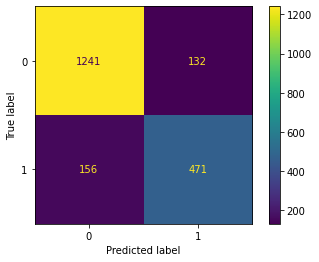

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred)).plot()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score(Y_test, np.where(predictive_model.predict(X_test) > 0.5, 1, 0))

0.8275281662409351

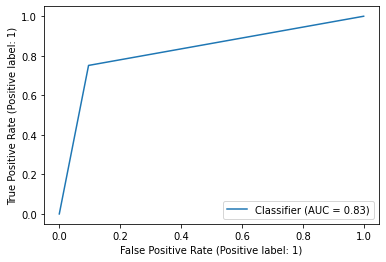

In [ ]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_true, y_pred)

In [ ]:
# ROC AUC GRAPH
no_skill_prediction_prob = [0 for _ in range(len(Y_test))]
predicted_prob = np.where(predictive_model.predict(X_test) > 0.5, 1, 0)
no_skill_prediction_auc = roc_auc_score(Y_test, no_skill_prediction_prob)
predicted_prob_auc = roc_auc_score(Y_test, np.where(predictive_model.predict(X_test) > 0.5, 1, 0))

# Summarize score
print('No Skill: ROC AUC=%.3f' % (no_skill_prediction_auc))
print('Logistic: ROC AUC=%.3f' % (predicted_prob_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.828


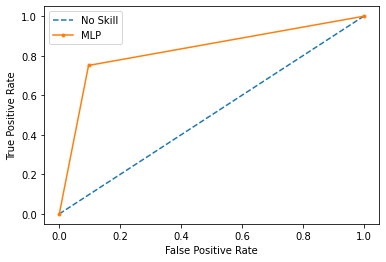

In [ ]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, no_skill_prediction_prob)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, np.where(predictive_model.predict(X_test) > 0.5, 1, 0))
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='MLP')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

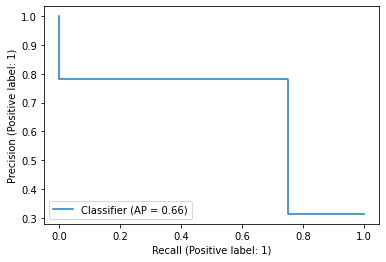

In [ ]:
# Precision Recall
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(Y_test, np.where(predictive_model.predict(X_test) > 0.5, 1, 0))

In [ ]:
from sklearn.metrics import average_precision_score
average_precision_score(Y_test, np.where(predictive_model.predict(X_test) > 0.5, 1, 0))

0.6647552191197125

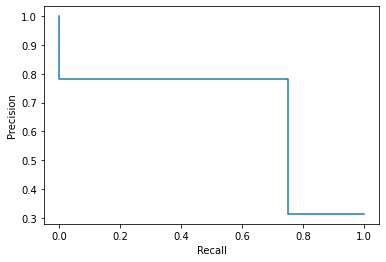

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(Y_test, np.where(predictive_model.predict(X_test) > 0.5, 1, 0))
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

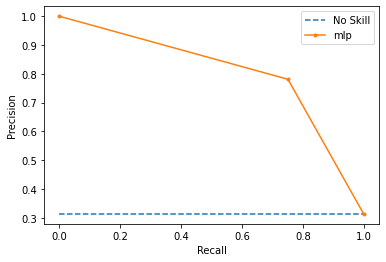

In [ ]:
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='mlp')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

**End of Project**